In [57]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append("C:/Users/haoyu/Documents/GitHub/XRaySimulation")

from XRaySimulation import Pulse, DeviceSimu, util, Crystal
plt.rcParams.update({'font.size': 22})


# Create Crystals for the miniSD
Unfortunately, the three corrdinate axes in this notebook corresponds to 
y,x,z direction in XPP

In [58]:
grating_distance_1 = 3.01e6
grating_distance_2 = 3.24e6
grating_period = 1.


def get_grating_and_crystals():
    energy_center = 9.5
    pre_length = 1e6

    # Set up the pulse
    FWHM = 50.  # (um)

    my_pulse = Pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=energy_center,
                                  polar=[1., 0., 0.],
                                  sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=9.,
                                  x0=np.array([0., 0., -pre_length - grating_distance_1]))

    ############################################################################################
    # Define gratings
    ###########################################################################################
    grating_list = [Crystal.RectangleGrating(), Crystal.RectangleGrating()]
    grating_list[0].set_a(grating_period / 2.)
    grating_list[0].set_b(grating_period / 2.)
    grating_list[1].set_a(grating_period / 2.)
    grating_list[1].set_b(grating_period / 2.)

    grating_list[0].set_surface_point(np.array([0, 0, -grating_distance_1]))
    grating_list[1].set_surface_point(np.array([0, 0, grating_distance_2]))

    #################################################################################################
    #                         VCC branch
    #################################################################################################
    # Define physical parameters
    h_length = 2. * np.pi / (1.9201 * 1e-4)

    # Some crystal properties
    chi_dict = {"chi0": complex(-0.97631E-05, 0.14871E-06),
                "chih_sigma": complex(0.59310E-05, -0.14320E-06),
                "chihbar_sigma": complex(0.59310E-05, -0.14320E-06),
                "chih_pi": complex(0.46945E-05, -0.11201E-06),
                "chihbar_pi": complex(0.46945E-05, -0.11201E-06),
                }

    # Get crystal_list
    thetas = np.pi / 2. * np.array([1, -1, -1, 1, 1, -1, -1, 1], dtype=np.float64)

    rhos = thetas + np.pi
    rhos[[1, 6]] -= np.deg2rad(5)
    rhos[[2, 5]] += np.deg2rad(5)

    vcc_crystals_local = [Crystal.CrystalBlock3D(h=np.array([0, np.sin(thetas[x]), np.cos(thetas[x])]) * h_length,
                                                 normal=np.array([0., np.sin(rhos[x]), np.cos(rhos[x])]),
                                                 surface_point=np.zeros(3),
                                                 thickness=1e6,
                                                 chi_dict=chi_dict)
                          for x in range(8)]

    # ----------------------------------------------------------------------
    #          Crystal 1
    # ----------------------------------------------------------------------
    boundary = np.array([[0, 10, 0],
                         [50, 10, 0],
                         [50, 0, 0],
                         [0, 0, 0]], dtype=np.float64) * 1000

    vcc_crystals_local[0].boundary = np.copy(boundary[:, [2, 1, 0]])
    vcc_crystals_local[0].set_surface_point(np.copy(vcc_crystals_local[0].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 2
    # ----------------------------------------------------------------------
    boundary = np.array([[25.070, 26.40, 0],
                         [90.070, 20.753, 0],
                         [90.070, 36.40, 0],
                         [25.070, 36.40, 0]], dtype=np.float64) * 1000

    vcc_crystals_local[1].boundary = np.copy(boundary[:, [2, 1, 0]])
    vcc_crystals_local[1].set_surface_point(np.copy(vcc_crystals_local[1].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 3
    # ----------------------------------------------------------------------
    boundary = np.copy(vcc_crystals_local[1].boundary)
    boundary[:, 2] *= -1

    vcc_crystals_local[2].boundary = np.copy(boundary)
    vcc_crystals_local[2].set_surface_point(np.copy(vcc_crystals_local[2].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 4
    # ----------------------------------------------------------------------
    boundary = np.copy(vcc_crystals_local[0].boundary)
    boundary[:, 2] *= -1

    vcc_crystals_local[3].boundary = np.copy(boundary)
    vcc_crystals_local[3].set_surface_point(np.copy(vcc_crystals_local[3].boundary[0]))

    # ----------------------------------------------------------------------
    #          Crystal 5
    # ----------------------------------------------------------------------
    vcc_crystals_local[4].boundary = np.copy(np.copy(vcc_crystals_local[3].boundary))
    vcc_crystals_local[4].set_surface_point(np.copy(vcc_crystals_local[4].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 7
    # ----------------------------------------------------------------------
    boundary = np.array([[25.070, 26.40, 0],
                         [90.070, 20.753, 0],
                         [90.070, 30.753, 0],
                         [25.070, 36.40, 0]], dtype=np.float64) * 1000

    vcc_crystals_local[6].boundary = np.copy(boundary[:, [2, 1, 0]])
    vcc_crystals_local[6].set_surface_point(np.copy(vcc_crystals_local[6].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 6
    # ----------------------------------------------------------------------
    boundary = np.copy(vcc_crystals_local[6].boundary)
    boundary[:, 2] *= -1

    vcc_crystals_local[5].boundary = np.copy(boundary)
    vcc_crystals_local[5].set_surface_point(np.copy(vcc_crystals_local[5].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 8
    # ----------------------------------------------------------------------
    vcc_crystals_local[7].boundary = np.copy(vcc_crystals_local[0].boundary)
    vcc_crystals_local[7].set_surface_point(np.copy(vcc_crystals_local[7].boundary[0]))

    # ---------------------------------------------------------------------------

    #################################################################################################
    #                         CC branch
    thetas = np.array([-np.pi / 2,
                       np.pi / 2,
                       np.pi / 2,
                       -np.pi / 2])
    rhos = thetas + np.pi

    cc_crystals_local = [Crystal.CrystalBlock3D(h=np.array([0, np.sin(thetas[x]), np.cos(thetas[x])]) * h_length,
                                                normal=np.array([0., np.sin(rhos[x]), np.cos(rhos[x])]),
                                                surface_point=np.zeros(3),
                                                thickness=1e6,
                                                chi_dict=chi_dict)
                         for x in range(4)]
    # ----------------------------------------------------------------------
    #          Crystal 1
    # ----------------------------------------------------------------------
    boundary = np.array([[-60, 12.57, 0],
                         [-20, 12.57, 0],
                         [-20, 22.57, 0],
                         [-22.68, 22.57, 0]])
    boundary -= np.array([-60, -22.57, 0])[np.newaxis, :]
    boundary *= 1000

    cc_crystals_local[0].boundary = np.copy(boundary[:, [2, 1, 0]])
    cc_crystals_local[0].set_surface_point(np.copy(cc_crystals_local[0].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 2
    # ----------------------------------------------------------------------
    boundary = np.array([[-60, -12.58, 0],
                         [60, -12.58, 0],
                         [60, -22.57, 0],
                         [-60, -22.57, 0]])
    boundary -= np.array([-60, -22.57, 0])[np.newaxis, :]
    boundary *= 1000

    cc_crystals_local[1].boundary = np.copy(boundary[:, [2, 1, 0]])
    cc_crystals_local[1].set_surface_point(np.copy(cc_crystals_local[1].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 3
    # ----------------------------------------------------------------------
    boundary = np.array([[-65, -12.90, 0],
                         [65, -12.90, 0],
                         [65, -22.90, 0],
                         [-65, -22.90, 0]])
    boundary -= np.array([-65, -22.90, 0])[np.newaxis, :]
    boundary *= 1000

    cc_crystals_local[2].boundary = np.copy(boundary[:, [2, 1, 0]])
    cc_crystals_local[2].set_surface_point(np.copy(cc_crystals_local[2].boundary[0]))
    # ----------------------------------------------------------------------
    #          Crystal 4
    # ----------------------------------------------------------------------
    boundary = np.array([[45, 12.90, 0],
                         [65, 12.90, 0],
                         [65, 22.90, 0],
                         [45, 22.90, 0]])
    boundary -= np.array([-65, -22.90, 0])[np.newaxis, :]
    boundary *= 1000

    cc_crystals_local[3].boundary = np.copy(boundary[:, [2, 1, 0]])
    cc_crystals_local[3].set_surface_point(np.copy(cc_crystals_local[3].boundary[0]))

    return my_pulse, grating_list, vcc_crystals_local, cc_crystals_local


def align_vcc_crystals(kin, crystals):
    kin_new = np.copy(kin)

    #####################################################
    #     Align CC1
    #####################################################
    rot_center = np.copy((crystals[0].boundary[0] + crystals[0].boundary[1]) / 2.)

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[0],
                                                        kin=kin_new,
                                                        rot_direction=-1.,
                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[1],
                                                axis=-crystals[0].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals[:2],
                                               kin=kin)
    kin_new = kin_new[-1]

    crystals[0].shift(-rot_center)
    crystals[1].shift(-rot_center)

    #####################################################
    #     Align CC2
    #####################################################
    rot_center = np.copy((crystals[3].boundary[0] + crystals[3].boundary[1]) / 2.)

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[2],
                                                        kin=kin_new,
                                                        rot_direction=1.,
                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[3],
                                                axis=-crystals[2].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals[:4],
                                               kin=kin)
    kin_new = kin_new[-1]

    crystals[2].shift(-rot_center)
    crystals[3].shift(-rot_center)
    #####################################################
    #     Align CC3
    #####################################################
    rot_center = (crystals[4].boundary[0] + crystals[4].boundary[1]) / 2.

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[4],
                                                        kin=kin_new,
                                                        rot_direction=1.,

                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[5],
                                                axis=-crystals[4].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals[:6],
                                               kin=kin)
    kin_new = kin_new[-1]

    crystals[4].shift(-rot_center)
    crystals[5].shift(-rot_center)
    #####################################################
    #     Align CC4
    #####################################################
    rot_center = (crystals[7].boundary[0] + crystals[7].boundary[1]) / 2.

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[6],
                                                        kin=kin_new,
                                                        rot_direction=-1.,
                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[7],
                                                axis=-crystals[6].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals,
                                               kin=kin)
    kin_new = kin_new[-1]
    crystals[6].shift(-rot_center)
    crystals[7].shift(-rot_center)

    return crystals, kin_new


def align_cc_crystals(kin, crystals):
    kin_new = np.copy(kin)

    #####################################################
    #     Align CC1
    #####################################################
    rot_center = np.copy((crystals[0].boundary[0]))

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[0],
                                                        kin=kin_new,
                                                        rot_direction=1.,
                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[1],
                                                axis=-crystals[0].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals[:2],
                                               kin=kin)
    kin_new = kin_new[-1]

    crystals[0].shift(-rot_center)
    crystals[1].shift(-rot_center)
    #####################################################
    #     Align CC2
    #####################################################
    rot_center = np.copy((crystals[3].boundary[0]))

    # Align the 1 crystal
    DeviceSimu.align_crystal_dynamical_bragg_reflection(crystal=crystals[2],
                                                        kin=kin_new,
                                                        rot_direction=-1.,
                                                        rot_center=rot_center)
    # Align the 2nd crystal
    DeviceSimu.align_crystal_reciprocal_lattice(crystal=crystals[3],
                                                axis=-crystals[2].h,
                                                rot_center=rot_center)

    # Get the kout from this crystal
    kin_new = DeviceSimu.get_kout_multi_device(device_list=crystals[:4],
                                               kin=kin)
    kin_new = kin_new[-1]

    crystals[2].shift(-rot_center)
    crystals[3].shift(-rot_center)
    return crystals, kin_new


def set_crystal_positions(vcc, cc):
    # CC1 of the CC branch is at the assumed position

    # First shift VCC1
    vcc[0].shift(np.array([0, 0, 198.51]) * 1e3)
    vcc[1].shift(np.array([0, 0, 198.51]) * 1e3)

    # Second shift VCC2
    vcc[2].shift(np.array([0, 0, 198.51 + 178.]) * 1e3)
    vcc[3].shift(np.array([0, 0, 198.51 + 178.]) * 1e3)

    # Third shift VCC3
    vcc[4].shift(np.array([0, 0, 198.51 + 178. + 223.49]) * 1e3)
    vcc[5].shift(np.array([0, 0, 198.51 + 178. + 223.49]) * 1e3)

    # Forth shift VCC3
    vcc[6].shift(np.array([0, 0, 198.51 + 178. + 223.49 + 225.01]) * 1e3)
    vcc[7].shift(np.array([0, 0, 198.51 + 178. + 223.49 + 225.01]) * 1e3)

    # Shift the second CC in CC branch
    cc[2].shift(np.array([0, 0, 198.51 + 178. + 223.49 + 225.01 + 225.01]) * 1e3)
    cc[3].shift(np.array([0, 0, 198.51 + 178. + 223.49 + 225.01 + 225.01]) * 1e3)


def get_trajectory(vcc_motion=np.zeros(8), cc_motion=np.zeros(4)):
    # Create the setup
    (my_pulse,
     grating_list,
     vcc_crystals_local,
     cc_crystals_local) = get_grating_and_crystals()

    kin_new = grating_list[0].base_wave_vector + my_pulse.k0
    _, vcc_kout = align_vcc_crystals(kin=kin_new, crystals=vcc_crystals_local)

    kin_new = -grating_list[0].base_wave_vector + my_pulse.k0
    _, cc_kout = align_cc_crystals(kin=kin_new, crystals=cc_crystals_local)

    set_crystal_positions(vcc=vcc_crystals_local, cc=cc_crystals_local)

    # Move the crystals along the y axis
    for x in range(8):
        vcc_crystals_local[x].shift(displacement=np.array([0., vcc_motion[x], 0.], dtype=np.float64))
    for x in range(4):
        cc_crystals_local[x].shift(displacement=np.array([0., cc_motion[x], 0.], dtype=np.float64))

    # Get the trajectory of VCC and CC branch
    device_list = [grating_list[0], ] + vcc_crystals_local + [grating_list[1], ]
    device_list[0].momentum_transfer = device_list[0].base_wave_vector
    device_list[-1].momentum_transfer = -device_list[-1].base_wave_vector

    (vcc_trajectory_local,
     vcc_kout_list_local,
     vcc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                                kin=my_pulse.k0,
                                                initial_point=my_pulse.x0,
                                                final_plane_point=np.array((0, 0, 10e6),
                                                                           dtype=np.float64),
                                                final_plane_normal=np.array((0, 0, -1),
                                                                            dtype=np.float64))
    vcc_trajectory_local = np.vstack(vcc_trajectory_local)
    vcc_kout_list_local = np.vstack(vcc_kout_list_local)

    device_list = [grating_list[0], ] + cc_crystals_local + [grating_list[1], ]
    device_list[0].momentum_transfer = -device_list[0].base_wave_vector
    device_list[-1].momentum_transfer = device_list[-1].base_wave_vector

    (cc_trajectory_local,
     cc_kout_list_local,
     cc_path_local) = DeviceSimu.get_lightpath(device_list=device_list,
                                               kin=my_pulse.k0,
                                               initial_point=my_pulse.x0,
                                               final_plane_point=np.array((0, 0, 10e6),
                                                                          dtype=np.float64),
                                               final_plane_normal=np.array((0, 0, -1),
                                                                           dtype=np.float64))
    cc_trajectory_local = np.vstack(cc_trajectory_local)
    cc_kout_list_local = np.vstack(cc_kout_list_local)

    return vcc_trajectory_local, vcc_kout_list_local, vcc_path_local, vcc_crystals_local, cc_trajectory_local, cc_kout_list_local, cc_path_local, cc_crystals_local


def tweak_horizontal_position_ratio(vcc_motion=np.zeros(8, dtype=np.float64),
                                    cc_motion=np.zeros(4, dtype=np.float64)):
    # Position1
    config1 = get_trajectory(vcc_motion=vcc_motion, cc_motion=cc_motion)

    # Position2
    config2 = get_trajectory(vcc_motion=vcc_motion + np.array([0, 0, 0, 0,
                                                               1, 1, -1, -1],
                                                              dtype=np.float64),
                             cc_motion=cc_motion)

    # Get the horizontal shift
    horizontal_shift = config2[0][-1][1] - config1[0][-1][1]

    print("t4x + 1um and t5x - 1um results in horizontal shift of {:.2f}um".format(horizontal_shift))
    return horizontal_shift, config1


def tweak_horizontal_overlap(vcc_motion=np.zeros(8, dtype=np.float64),
                             cc_motion=np.zeros(4, dtype=np.float64)):
    # Get ratio
    horizontal_shift_per_um, current_config = tweak_horizontal_position_ratio(vcc_motion=vcc_motion,
                                                                              cc_motion=cc_motion)

    # Get the distance
    tweak_size = (current_config[4][-1][1] - current_config[0][-1][1]) / horizontal_shift_per_um
    print("To get two pulse overlap, t4x should move {:.2f} um, t5x should move {:.2f} um".format(tweak_size,
                                                                                                  - tweak_size))
    return tweak_size


def tweak_temporal(vcc_motion=np.zeros(8, dtype=np.float64),
                   cc_motion=np.zeros(4, dtype=np.float64)):
    # Position1
    config1 = get_trajectory(vcc_motion=vcc_motion, cc_motion=cc_motion)

    # Position2
    config2 = get_trajectory(vcc_motion=vcc_motion + np.array([1, 1, 1, 1,
                                                               0, 0, 0, 0],
                                                              dtype=np.float64),
                             cc_motion=cc_motion)

    # Get the horizontal shift
    temporal_shift = config2[2] - config1[2]

    print("t23 +1 um results in temporal delay of {:.2f}fs".format(temporal_shift / util.c))
    return temporal_shift, config1


def tweak_temporal_overlap(vcc_motion=np.zeros(8, dtype=np.float64),
                           cc_motion=np.zeros(4, dtype=np.float64)):
    # Get ratio
    temporal_shift_per_um, current_config = tweak_temporal(vcc_motion=vcc_motion,
                                                           cc_motion=cc_motion)

    # Get the distance
    tweak_size_local = (current_config[6] - current_config[2]) / temporal_shift_per_um
    print("To get two pulse overlap, t23 should move {:.2f} um".format(tweak_size_local))
    return tweak_size_local


In [59]:
t2_offset = 2100
t5_offset = 2880
tweak_size = tweak_horizontal_overlap(vcc_motion=np.array([t2_offset, t2_offset,
                                                           0, 0,
                                                           0, 0,
                                                           t5_offset, t5_offset, ]),
                                      cc_motion=np.array([0, 0,
                                                          600, 600]))

t23_tweak_size = tweak_temporal_overlap(vcc_motion=np.array([t2_offset, t2_offset,
                                                             0, 0,
                                                             tweak_size, tweak_size,
                                                             -tweak_size + t5_offset, -tweak_size + t5_offset, ]),
                                        cc_motion=np.array([0, 0,
                                                            600, 600]))

t4x + 1um and t5x - 1um results in horizontal shift of 1.28um
To get two pulse overlap, t4x should move 51.20 um, t5x should move -51.20 um
t23 +1 um results in temporal delay of 0.94fs
To get two pulse overlap, t23 should move -4006.16 um


In [60]:
(vcc_trajectory,
 vcc_kout_list,
 vcc_path,
 vcc_crystals,
 cc_trajectory,
 cc_kout_list,
 cc_path,
 cc_crystals) = get_trajectory(vcc_motion=np.array([t23_tweak_size + t2_offset, t23_tweak_size + t2_offset,
                                                    t23_tweak_size, t23_tweak_size,
                                                    tweak_size, tweak_size,
                                                    -tweak_size + t5_offset, -tweak_size + t5_offset, ]),
                               cc_motion=np.array([0, 0,
                                                   600, 600]))

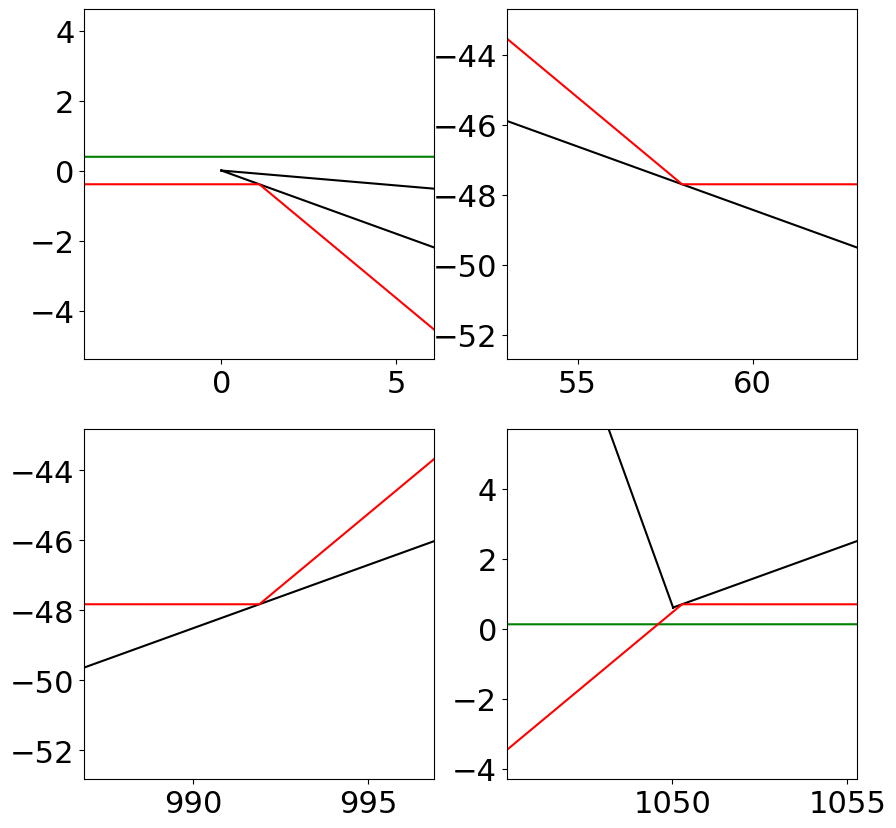

In [61]:
#############################################
#  The intersection point on the lower branch
#############################################
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)

for n1 in range(2):
    for n2 in range(2):
        ax = axes[n1, n2]

        for x in range(8):
            ax.plot([vcc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
                    [vcc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
                    'k')

        for x in range(4):
            ax.plot([cc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
                    [cc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
                    'k')

        ax.plot(vcc_trajectory[:, 2] / 1000,
                vcc_trajectory[:, 1] / 1000, 'g')

        ax.plot(cc_trajectory[:, 2] / 1000,
                cc_trajectory[:, 1] / 1000, 'r')

        idx = 2 * n1 + n2 + 2
        ax.set_aspect("equal")
        ax.set_xlim([cc_trajectory[idx, 2] / 1000 - 5, cc_trajectory[idx, 2] / 1000 + 5])
        ax.set_ylim([cc_trajectory[idx, 1] / 1000 - 5, cc_trajectory[idx, 1] / 1000 + 5])

plt.show()

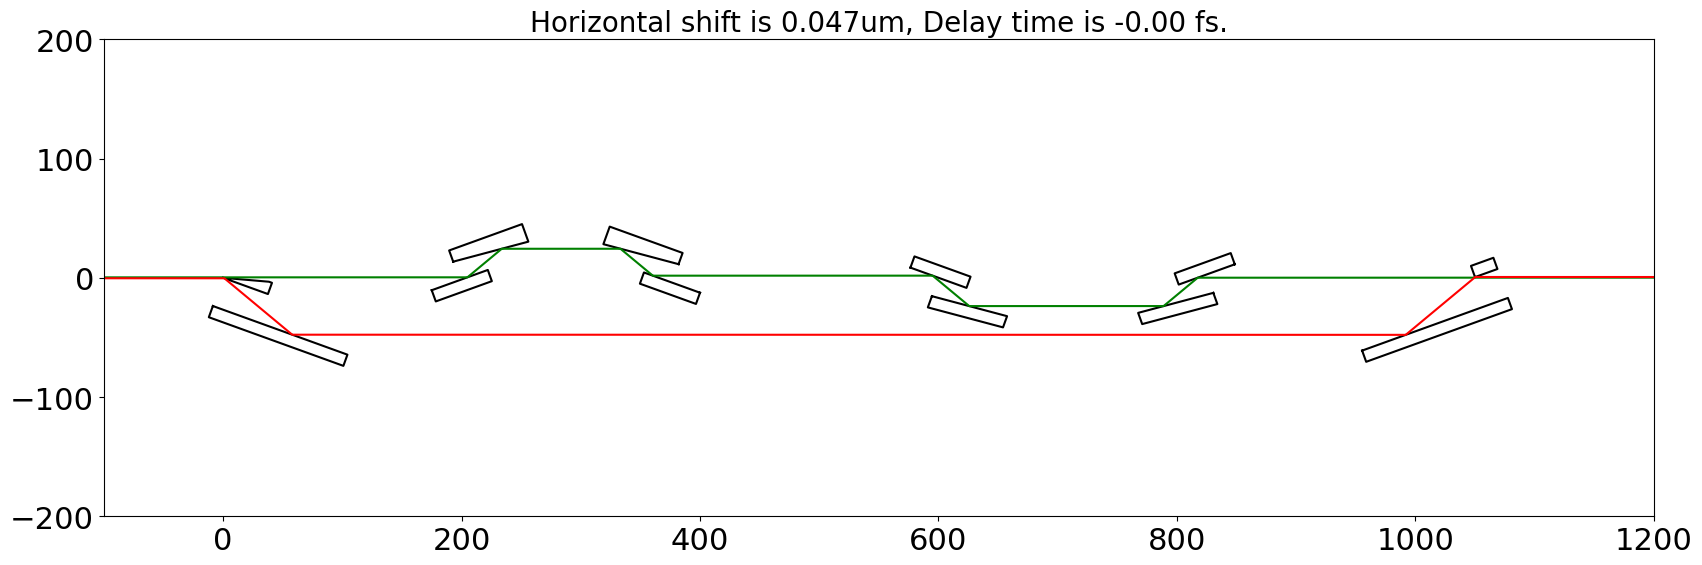

In [62]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([vcc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [vcc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

for x in range(4):
    ax.plot([cc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [cc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(vcc_trajectory[:, 2] / 1000,
        vcc_trajectory[:, 1] / 1000, 'g')

ax.plot(cc_trajectory[:, 2] / 1000,
        cc_trajectory[:, 1] / 1000, 'r')

ax.set_aspect("equal")
ax.set_ylim([-200, 200])
ax.set_xlim([-100, 1200])
ax.set_title(
    "Horizontal shift is {:.2}um, Delay time is {:.2f} fs.".format(vcc_trajectory[-1][1] - cc_trajectory[-1][1],
                                                                   (vcc_path - cc_path) / util.c),
    fontsize=20)

plt.show()

# Step 2: Create grating and mirrors for the transient grating

In [63]:
energy_center = 9.5
pre_length = 1e6

# Set up the pulse
FWHM = 50.  # (um)

my_pulse = Pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[1., 0., 0.],
                              sigma_x=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM / 2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=9.,
                              x0=np.array([0., 0., -pre_length - grating_distance_1]))

In [64]:
# Duplicate the crystals that were defined previously
grating_list = [Crystal.RectangleGrating(), Crystal.RectangleGrating()]
grating_list[0].set_a(grating_period / 2.)
grating_list[0].set_b(grating_period / 2.)
grating_list[1].set_a(grating_period / 2.)
grating_list[1].set_b(grating_period / 2.)

grating_list[0].set_surface_point(np.array([0, 0, -grating_distance_1]))
grating_list[1].set_surface_point(np.array([0, 0, grating_distance_2]))

grating_list[0].set_diffraction_order(1)
grating_list[1].set_diffraction_order(-1)

# Calculate the TG pulse from the VCC branch

grating3a = Crystal.RectangleGrating()
grating3a.set_a(0.25)  # For a period of 0.5um
grating3a.set_b(0.25)
grating3a.set_surface_point(np.array([0, 0, 1.2e6]))
grating3a.set_diffraction_order(1)

grating3b = Crystal.RectangleGrating()
grating3b.set_a(0.25)  # For a period of 0.5um
grating3b.set_b(0.25)
grating3b.set_surface_point(np.array([0, 0, 1.2e6]))
grating3b.set_diffraction_order(-1)

# Define the mirrors for each branch
mirror_angle_1 = np.deg2rad(0.4)
mirror_angle_2 = np.deg2rad(0.4)

mirror_angle_3 = np.deg2rad(0.001)
mirror_angle_4 = np.deg2rad(12.012)

# The mirror 1 and mirror 2 are used for the TG pulse
mirror1 = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, 10e6]),
                                        normal=np.array([0, -np.sin(mirror_angle_1), np.cos(mirror_angle_1)]))

mirror2 = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, 10e6]),
                                        normal=np.array([0, np.sin(mirror_angle_2), np.cos(mirror_angle_1)]))

# The mirror 3 and 4 are for the trajectory for the probe pulse
mirror3 = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, 2e6]),
                                        normal=np.array([np.sin(mirror_angle_3), 0, np.cos(mirror_angle_3)]))

mirror4 = Crystal.TotalReflectionMirror(surface_point=np.array([0, 0, 10.161e6]),
                                        normal=np.array([-np.sin(mirror_angle_4), 0, np.cos(mirror_angle_4)]))


# Get the trajectory of VCC for the TG measurement
device_list_TGa = [grating_list[0], ] + vcc_crystals + [grating3a, mirror1, ]
device_list_TGb = [grating_list[0], ] + vcc_crystals + [grating3b, mirror2, ]

device_list_probe = [grating_list[0], ] + cc_crystals + [mirror3, mirror4, ]

# Get the trajectory of one branch of the TG
(TGa_trajectory,
 TGa_kout_list,
 TGa_path) = DeviceSimu.get_lightpath(device_list=device_list_TGa,
                                      kin=my_pulse.k0,
                                      initial_point=my_pulse.x0,
                                      final_plane_point=np.array((0, 0, 10.163e6),
                                                                 dtype=np.float64),
                                      final_plane_normal=np.array((0, 0, -1),
                                                                  dtype=np.float64))

(TGb_trajectory,
 TGb_kout_list,
 TGb_path) = DeviceSimu.get_lightpath(device_list=device_list_TGb,
                                      kin=my_pulse.k0,
                                      initial_point=my_pulse.x0,
                                      final_plane_point=np.array((0, 0, 10.163e6),
                                                                 dtype=np.float64),
                                      final_plane_normal=np.array((0, 0, -1),
                                                                  dtype=np.float64))

(probe_trajectory,
 probe_kout_list,
 probe_path) = DeviceSimu.get_lightpath(device_list=device_list_probe,
                                      kin=my_pulse.k0,
                                      initial_point=my_pulse.x0,
                                      final_plane_point=np.array((0, 0, 10.163e6),
                                                                 dtype=np.float64),
                                      final_plane_normal=np.array((0, 0, -1),
                                                                  dtype=np.float64))


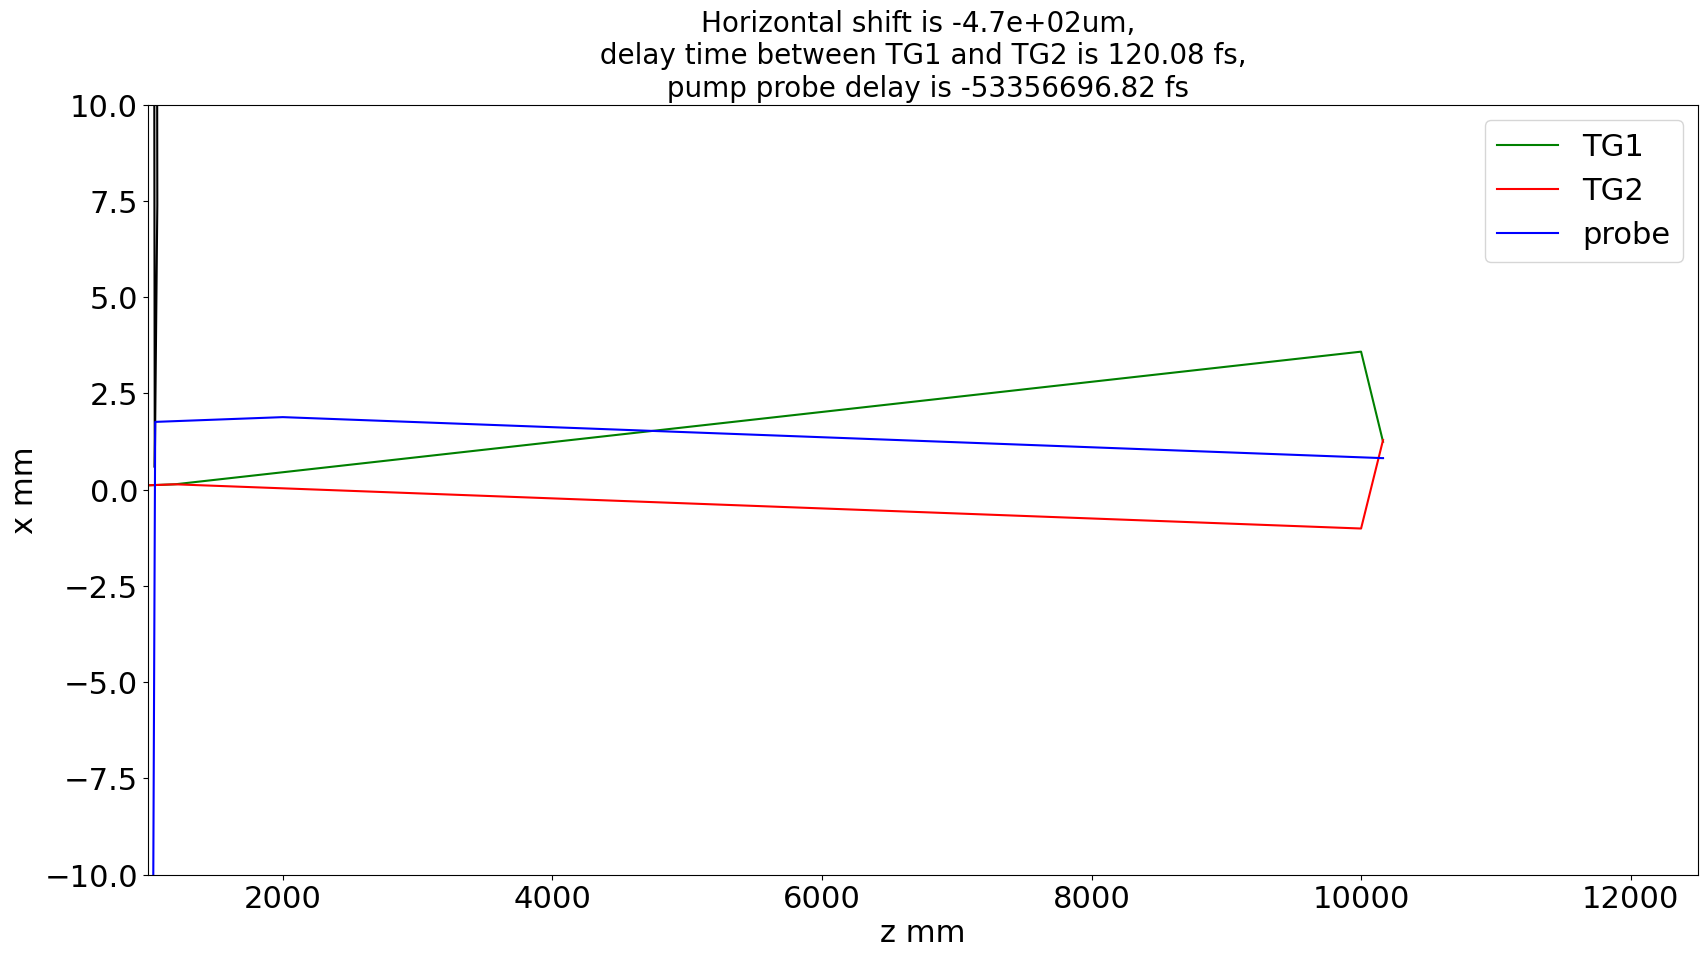

In [74]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([vcc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [vcc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

for x in range(4):
    ax.plot([cc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [cc_crystals[x].boundary[y][1] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(np.array(TGa_trajectory)[:, 2] / 1000,
        np.array(TGa_trajectory)[:, 1] / 1000, 'g', label='TG1')

ax.plot(np.array(TGb_trajectory)[:, 2] / 1000,
        np.array(TGb_trajectory)[:, 1] / 1000, 'r', label='TG2')

ax.plot(np.array(probe_trajectory)[:, 2] / 1000,
        np.array(probe_trajectory)[:, 1] / 1000, 'b', label='probe')


ax.set_aspect("auto")
ax.set_ylim([-10, 10])
ax.set_xlabel("z mm")
ax.set_ylabel("x mm")
ax.set_xlim([0, 1250])
ax.set_xlim([1000, 12500])
ax.legend(loc='upper right')
ax.set_title(
    "Horizontal shift is {:.2}um, \n delay time between TG1 and TG2 is {:.2f} fs, \n pump probe delay is {:.2f} fs".format(
        probe_trajectory[-1][1] - TGb_trajectory[-1][1],
        (TGa_path - TGb_path) / util.c,
        (probe_path - TGb_path) / util.c
    ),
    fontsize=20)

plt.show()

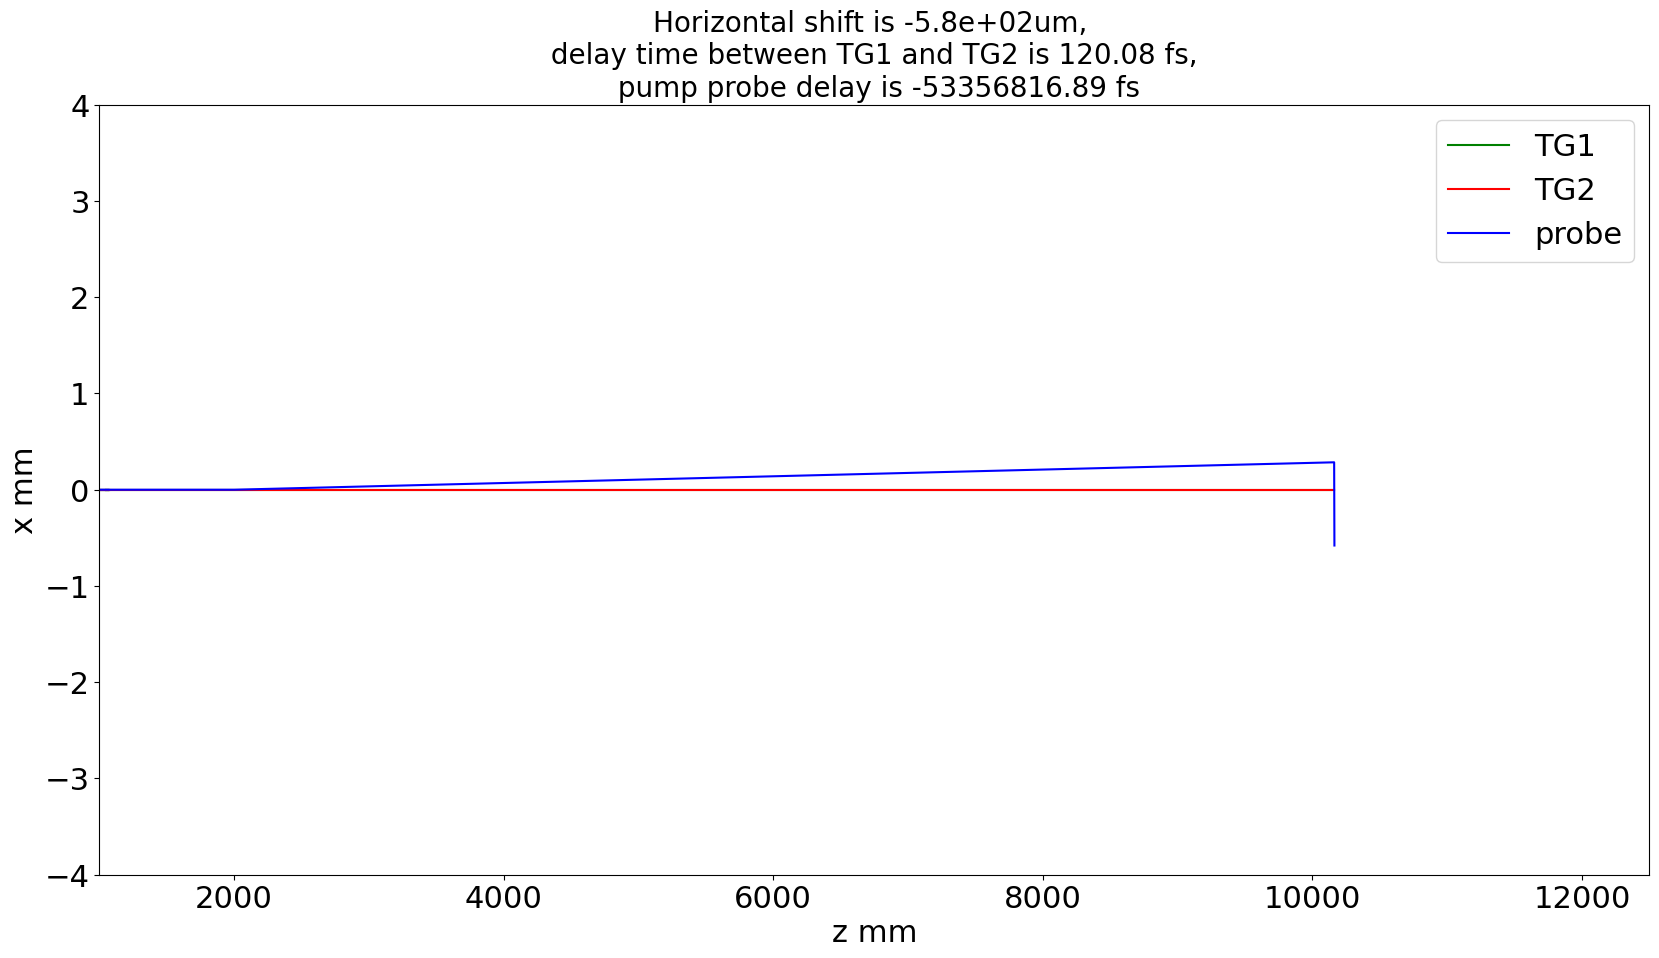

In [68]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for x in range(8):
    ax.plot([vcc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [vcc_crystals[x].boundary[y][0] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

for x in range(4):
    ax.plot([cc_crystals[x].boundary[y][2] / 1000 for y in [0, 1, 2, 3, 0]],
            [cc_crystals[x].boundary[y][0] / 1000 for y in [0, 1, 2, 3, 0]],
            'k')

ax.plot(np.array(TGa_trajectory)[:, 2] / 1000,
        np.array(TGa_trajectory)[:, 0] / 1000, 'g', label='TG1')

ax.plot(np.array(TGb_trajectory)[:, 2] / 1000,
        np.array(TGb_trajectory)[:, 0] / 1000, 'r', label='TG2')

ax.plot(np.array(probe_trajectory)[:, 2] / 1000,
        np.array(probe_trajectory)[:, 0] / 1000, 'b', label='probe')


ax.set_aspect("auto")
ax.set_ylim([-4, 4])
ax.set_xlabel("z mm")
ax.set_ylabel("x mm")
ax.set_xlim([1000, 12500])
ax.legend(loc='upper right')
ax.set_title(
    "Horizontal shift is {:.2}um, \n delay time between TG1 and TG2 is {:.2f} fs, \n pump probe delay is {:.2f} fs".format(
        probe_trajectory[-1][0] - TGb_trajectory[-1][0],
        (TGa_path - TGb_path) / util.c,
        (probe_path - TGa_path) / util.c
    ),
    fontsize=20)

plt.show()

In [67]:
(probe_path - TGb_path) / util.c / 1e6

-53.35669681521813